In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('04-data/preprocessed_app_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22010 entries, 0 to 22009
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     22010 non-null  object 
 1   description               22010 non-null  object 
 2   summary                   22009 non-null  object 
 3   installs                  22010 non-null  object 
 4   minInstalls               22010 non-null  float64
 5   score                     22010 non-null  float64
 6   ratings                   22010 non-null  float64
 7   reviews                   22010 non-null  float64
 8   histogram                 22010 non-null  object 
 9   price                     22010 non-null  float64
 10  free                      22010 non-null  int64  
 11  currency                  22010 non-null  object 
 12  sale                      22010 non-null  bool   
 13  offersIAP                 22010 non-null  bool   
 14  inAppP

In [3]:
df_sentiment = pd.read_csv('04-data/sentiment_topics_apps.csv')

In [4]:
df= pd.merge(
    df,
    df_sentiment,
    how="inner",
    on='appId',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [5]:
df.shape

(21997, 63)

In [6]:
df = df[df['genre'] != 'Events']

In [7]:
df.columns

Index(['title', 'description', 'summary', 'installs', 'minInstalls', 'score',
       'ratings', 'reviews', 'histogram', 'price', 'free', 'currency', 'sale',
       'offersIAP', 'inAppProductPrice', 'size', 'androidVersion',
       'androidVersionText', 'developer', 'developerId', 'privacyPolicy',
       'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'comments', 'editorsChoice',
       'appId', 'url', 'year', 'updated_year', 'description_clean',
       'hist_clean', 'star_1', 'star_2', 'star_3', 'star_4', 'star_5',
       'top_developer', 'current_date', 'days', 'installs_day', 'updated_days',
       'has_video', 'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support'],
      dtype='object')

In [8]:
df.ratings.describe()

count     21987.000000
mean      21185.978578
std       29240.424610
min        1000.000000
25%        5486.500000
50%       11388.000000
75%       24635.500000
max      398867.000000
Name: ratings, dtype: float64

In [9]:
df.sort_values('ratings',ascending=False).head(60)

,title,description,summary,installs,minInstalls,score,ratings,reviews,histogram,price,...,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support
7434,Survival Arena,"To all who love battles, strategic planning an...",Non-stop explosive TD action!,"1,000,000+",1000000.0,4.377266,398867.0,99182.0,"[9976, 6005, 43087, 104290, 235509]",0.00,...,717.360115,196,1,0.452737,0.636900,-0.068022,0.226121,0.238540,0.432880,0.000000
2250,Gods of Olympus,Command the gods of Olympus as they battle thr...,Command the gods of Olympus as they battle thr...,"1,000,000+",1000000.0,4.534874,396932.0,174064.0,"[13449, 5322, 22353, 70153, 285655]",0.00,...,616.903146,54,1,0.445667,0.173633,-0.086000,0.307318,0.182341,0.220200,0.111333
15152,Skill Academy by Ruangguru,"Skill Academy, the latest service by Ruangguru...",Online learning platform for upskilling to opt...,"1,000,000+",1000000.0,4.944825,368224.0,338441.0,"[2658, 612, 1531, 4782, 358641]",0.00,...,2232.142857,7,1,0.690800,-0.532400,0.038570,0.005271,-0.032100,0.000000,0.655900
12497,Guardian Hunter: SuperBrawlRPG [Online],( Please note that this game requires an inter...,Feeling-of-Hit is alive! Fantasy Action RPG,"1,000,000+",1000000.0,4.345733,366019.0,198854.0,"[26606, 9043, 24880, 56157, 249333]",0.00,...,481.927711,9,1,0.170375,0.487700,0.029650,0.191963,0.133978,0.201522,0.444433
7275,Survivors: The Quest,<b>Can you survive long enough to discover the...,Can you survive long enough to discover the is...,"1,000,000+",1000000.0,4.233251,364749.0,153009.0,"[13898, 12144, 51308, 85028, 202371]",0.00,...,499.251123,224,1,0.308222,-0.210633,0.000000,0.202577,0.395850,-0.042886,0.604233
3861,Make Money: Cash Rewards & Gift Cards,Were you searching for:\r\n\r\nHow to make eas...,Highest Paying Cash App – Earn Real Money Rewa...,"1,000,000+",1000000.0,4.657820,362672.0,244405.0,"[11691, 4688, 16221, 30823, 299249]",0.00,...,685.871056,63,1,0.308287,0.159575,0.344733,0.360117,0.000000,0.215656,0.175067
20650,Purrfect Spirits,"A flash of white light, and whoosh! Turns out ...",Daily fun with cats...in death,"1,000,000+",1000000.0,4.778073,360136.0,189652.0,"[4107, 2442, 9561, 37040, 306986]",0.00,...,789.265983,59,1,0.554412,0.286000,0.315667,0.406346,-0.111867,0.657720,0.813650
7595,Questland: Turn Based RPG,"Embark on an epic quest in this <font color=""#...","Fantasy RPG full of epic loot, turn based batt...","1,000,000+",1000000.0,4.767443,355048.0,108467.0,"[7547, 2724, 7468, 29266, 308043]",0.00,...,945.179584,0,1,0.227529,0.000000,-0.075025,0.306247,0.139100,0.262020,0.562100
4149,Tiny Gladiators - Fighting Tournament,<b>Tiny Gladiators is an action-packed RPG Fig...,RPG Fighting Games – Knockout the Competition ...,"1,000,000+",1000000.0,4.611953,353351.0,126373.0,"[16522, 4485, 13226, 31117, 288001]",0.00,...,699.790063,233,1,0.382643,0.534000,0.238200,0.291242,0.088991,0.453478,0.000000
19189,TikBooster - Get Followers & Fans & Likes & He...,Do you want to be more popular on Tik Tok (Mus...,More Fans &Followers. Increase the Likes & Hea...,"1,000,000+",1000000.0,4.691223,347204.0,221786.0,"[14712, 4163, 8694, 18479, 301156]",0.00,...,2816.901408,35,0,0.540786,0.038408,0.000000,0.097046,0.000000,0.000000,0.000000


In [10]:
X = df[['ratings','free','containsAds','genre','editorsChoice','contentRating','year','top_developer',
        'installs_day','updated_days','has_video', 'app_ads', 'compatibility', 'updates', 
        'features', 'bugs','payments', 'use_support']]

y = df['score']

In [11]:
# Split to create temporary tr and test 
X_tr, X_test, y_tr, y_test = train_test_split(X, y,test_size=.20, random_state=10)
#10

In [12]:
X_tr_cont = X_tr[['ratings','free','containsAds','editorsChoice','top_developer',
        'installs_day','updated_days','has_video', 'app_ads', 'compatibility', 'updates', 'features', 'bugs',
       'payments', 'use_support','year']]

In [13]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_tr[['genre','contentRating']])

ohe_x_tr = ohe.transform(X_tr[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_tr_df = pd.DataFrame(ohe_x_tr, columns=columns, index=X_tr.index)

In [14]:
combo_train_df = pd.concat([X_tr_cont, ohe_x_tr_df], axis=1)

In [15]:
combo_train_df.columns

Index(['ratings', 'free', 'containsAds', 'editorsChoice', 'top_developer',
       'installs_day', 'updated_days', 'has_video', 'app_ads', 'compatibility',
       'updates', 'features', 'bugs', 'payments', 'use_support', 'year',
       'genre_Action', 'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Finance', 'genre_Food & Drink', 'genre_Health & Fitness',
       'genre_House & Home', 'genre_Libraries & Demo', 'genre_Lifestyle',
       'genre_Maps & Navigation', 'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopp

In [16]:
## Add interactions
combo_train_df['use_support_weather'] = combo_train_df['use_support'] * combo_train_df['genre_Weather']
combo_train_df['use_support_shopping'] = combo_train_df['use_support'] * combo_train_df['genre_Shopping']
combo_train_df['use_support_education'] = combo_train_df['use_support'] * combo_train_df['genre_Education']
combo_train_df['use_support_Books'] = combo_train_df['use_support'] * combo_train_df['genre_Books & Reference']
combo_train_df['use_support_comics'] = combo_train_df['use_support'] * combo_train_df['genre_Comics']
combo_train_df['use_support_video'] = combo_train_df['use_support'] * combo_train_df['genre_Video Players & Editors']

combo_train_df['payments_food'] = combo_train_df['payments'] * combo_train_df['genre_Food & Drink']
combo_train_df['payments_medical'] = combo_train_df['payments'] * combo_train_df['genre_Medical']
combo_train_df['payments_shopping'] = combo_train_df['payments'] * combo_train_df['genre_Shopping']
combo_train_df['payments_news'] = combo_train_df['payments'] * combo_train_df['genre_News & Magazines']
combo_train_df['payments_casino'] = combo_train_df['payments'] * combo_train_df['genre_Casino']

combo_train_df['bugs_dating'] = combo_train_df['bugs'] * combo_train_df['genre_Dating']
combo_train_df['bugs_social'] = combo_train_df['bugs'] * combo_train_df['genre_Social']
combo_train_df['bugs_news'] = combo_train_df['bugs'] * combo_train_df['genre_News & Magazines']
combo_train_df['bugs_libraries'] = combo_train_df['bugs'] * combo_train_df['genre_Libraries & Demo']
combo_train_df['bugs_health'] = combo_train_df['bugs'] * combo_train_df['genre_Health & Fitness']
combo_train_df['bugs_casual'] = combo_train_df['bugs'] * combo_train_df['genre_Casual']
combo_train_df['bugs_comics'] = combo_train_df['bugs'] * combo_train_df['genre_Comics']

combo_train_df['features_tools'] = combo_train_df['features'] * combo_train_df['genre_Tools']
combo_train_df['features_news'] = combo_train_df['features'] * combo_train_df['genre_News & Magazines']
combo_train_df['features_music'] = combo_train_df['features'] * combo_train_df['genre_Music & Audio']
combo_train_df['features_card'] = combo_train_df['features'] * combo_train_df['genre_Card']
combo_train_df['features_business'] = combo_train_df['features'] * combo_train_df['genre_Business']
combo_train_df['features_house'] = combo_train_df['features'] * combo_train_df['genre_House & Home']

combo_train_df['updates_library'] = combo_train_df['updates'] * combo_train_df['genre_Libraries & Demo']
combo_train_df['updates_payments'] = combo_train_df['updates'] * combo_train_df['payments']
combo_train_df['updates_shopping'] = combo_train_df['updates'] * combo_train_df['genre_Shopping']
#combo_train_df['updates_events'] = combo_train_df['updates'] * combo_train_df['genre_Events']
combo_train_df['updates_art'] = combo_train_df['updates'] * combo_train_df['genre_Art & Design']

combo_train_df['app_ads_social'] = combo_train_df['app_ads'] * combo_train_df['genre_Social']
combo_train_df['app_ads_art'] = combo_train_df['app_ads'] * combo_train_df['genre_Art & Design']
combo_train_df['app_ads_strategy'] = combo_train_df['app_ads'] * combo_train_df['genre_Strategy']
combo_train_df['app_ads_features'] = combo_train_df['app_ads'] * combo_train_df['features']
combo_train_df['app_ads_tools'] = combo_train_df['app_ads'] * combo_train_df['genre_Tools']
combo_train_df['app_ads_entertainment'] = combo_train_df['app_ads'] * combo_train_df['genre_Entertainment']
combo_train_df['app_ads_house'] = combo_train_df['app_ads'] * combo_train_df['genre_House & Home']

combo_train_df['edchoice_Mature'] = combo_train_df['editorsChoice'] * combo_train_df['contentRating_Mature 17+']
combo_train_df['edchoice_teen'] = combo_train_df['editorsChoice'] * combo_train_df['contentRating_Teen']
combo_train_df['edchoice_education'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Education']
combo_train_df['edchoice_house'] = combo_train_df['editorsChoice'] * combo_train_df['genre_House & Home']
combo_train_df['edchoice_art'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Art & Design']
#combo_train_df['edchoice_events'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Events']
combo_train_df['edchoice_finance'] = combo_train_df['editorsChoice'] * combo_train_df['genre_Finance']

combo_train_df['ads_adventure'] = combo_train_df['containsAds'] * combo_train_df['genre_Adventure']
combo_train_df['ads_beauty'] = combo_train_df['containsAds'] * combo_train_df['genre_Beauty']
combo_train_df['ads_card'] = combo_train_df['containsAds'] * combo_train_df['genre_Card']
combo_train_df['ads_finance'] = combo_train_df['containsAds'] * combo_train_df['genre_Finance']
combo_train_df['ads_business'] = combo_train_df['containsAds'] * combo_train_df['genre_Business']
combo_train_df['ads_appads'] = combo_train_df['containsAds'] * combo_train_df['app_ads']
combo_train_df['ads_health'] = combo_train_df['containsAds'] * combo_train_df['genre_Health & Fitness']
combo_train_df['ads_roleplay'] = combo_train_df['containsAds'] * combo_train_df['genre_Role Playing']
combo_train_df['ads_maps'] = combo_train_df['containsAds'] * combo_train_df['genre_Maps & Navigation']
combo_train_df['ads_photography'] = combo_train_df['containsAds'] * combo_train_df['genre_Photography']

#combo_train_df['compatibility_events'] = combo_train_df['compatibility'] * combo_train_df['genre_Events']
combo_train_df['compatibility_medical'] = combo_train_df['compatibility'] * combo_train_df['genre_Medical']
combo_train_df['compatibility_productivity'] = combo_train_df['compatibility'] * combo_train_df['genre_Productivity']
combo_train_df['compatibility_adventure'] = combo_train_df['compatibility'] * combo_train_df['genre_Adventure']
combo_train_df['compatibility_communication'] = combo_train_df['compatibility'] * combo_train_df['genre_Communication']
combo_train_df['compatibility_news'] = combo_train_df['compatibility'] * combo_train_df['genre_News & Magazines']
combo_train_df['compatibility_features'] = combo_train_df['compatibility'] * combo_train_df['features']

combo_train_df['video_medical'] = combo_train_df['has_video'] * combo_train_df['genre_Medical']
combo_train_df['video_library'] = combo_train_df['has_video'] * combo_train_df['genre_Libraries & Demo']
combo_train_df['video_sport'] = combo_train_df['has_video'] * combo_train_df['genre_Sports']
combo_train_df['video_comics'] = combo_train_df['has_video'] * combo_train_df['genre_Comics']

combo_train_df['topdev_video'] = combo_train_df['top_developer'] * combo_train_df['genre_Video Players & Editors']
combo_train_df['topdev_features'] = combo_train_df['top_developer'] * combo_train_df['features']
combo_train_df['topdev_personalization'] = combo_train_df['top_developer'] * combo_train_df['genre_Personalization']

combo_train_df['free_simulation'] = combo_train_df['free'] * combo_train_df['genre_Simulation']
combo_train_df['free_Photography'] = combo_train_df['free'] * combo_train_df['genre_Photography']

In [17]:
# Further split temporary tr to create train and val
X_train, X_val, y_train, y_val = train_test_split(combo_train_df, y_tr,test_size=.20, random_state=10)

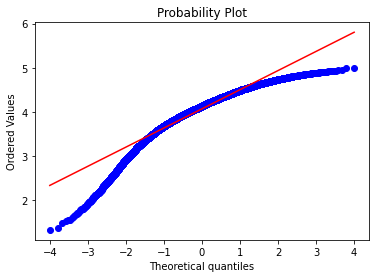

In [18]:
from scipy import stats 
fig = plt.figure() 
prob = stats.probplot(df['score'], plot=plt)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


- Total number of ratings: 21987
- Mean of distribution of rating : 4.0676891002683195
- Standard deviation: 0.4488755964730774


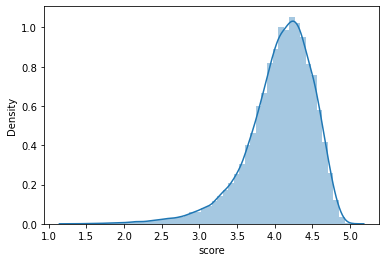

In [19]:
sns.distplot(df['score'])
print('- Total number of ratings:', len(df['score']))
print('- Mean of distribution of rating :', np.mean(df['score']))
print('- Standard deviation:', np.std(df['score']))
plt.savefig('test.svg')

## No pipeline

In [20]:
X_train.columns.values.tolist()

['ratings',
 'free',
 'containsAds',
 'editorsChoice',
 'top_developer',
 'installs_day',
 'updated_days',
 'has_video',
 'app_ads',
 'compatibility',
 'updates',
 'features',
 'bugs',
 'payments',
 'use_support',
 'year',
 'genre_Action',
 'genre_Adventure',
 'genre_Arcade',
 'genre_Art & Design',
 'genre_Auto & Vehicles',
 'genre_Beauty',
 'genre_Board',
 'genre_Books & Reference',
 'genre_Business',
 'genre_Card',
 'genre_Casino',
 'genre_Casual',
 'genre_Comics',
 'genre_Communication',
 'genre_Dating',
 'genre_Education',
 'genre_Entertainment',
 'genre_Finance',
 'genre_Food & Drink',
 'genre_Health & Fitness',
 'genre_House & Home',
 'genre_Libraries & Demo',
 'genre_Lifestyle',
 'genre_Maps & Navigation',
 'genre_Medical',
 'genre_Music & Audio',
 'genre_News & Magazines',
 'genre_Parenting',
 'genre_Personalization',
 'genre_Photography',
 'genre_Productivity',
 'genre_Puzzle',
 'genre_Racing',
 'genre_Role Playing',
 'genre_Shopping',
 'genre_Simulation',
 'genre_Social',
 'g

In [21]:
features = ['ratings',
 'free',
 'containsAds',
 'editorsChoice',
 'top_developer',
 'installs_day',
 'updated_days',
 'has_video',
 'app_ads',
 'compatibility',
 'updates',
 'features',
 'bugs',
 'payments',
 'use_support',
 'year',
 'genre_Adventure',
 'genre_Arcade',
 'genre_Art & Design',
 'genre_Auto & Vehicles',
 'genre_Beauty',
 'genre_Board',
 'genre_Books & Reference',
 'genre_Business',
 'genre_Card',
 'genre_Casino',
 'genre_Casual',
 'genre_Comics',
 'genre_Communication',
 'genre_Dating',
 'genre_Education',
 'genre_Entertainment',
 'genre_Finance',
 'genre_Food & Drink',
 'genre_Health & Fitness',
 'genre_House & Home',
 'genre_Libraries & Demo',
 'genre_Lifestyle',
 'genre_Maps & Navigation',
 'genre_Medical',
 'genre_Music & Audio',
 'genre_News & Magazines',
 'genre_Parenting',
 'genre_Personalization',
 'genre_Photography',
 'genre_Productivity',
 'genre_Puzzle',
 'genre_Racing',
 'genre_Role Playing',
 'genre_Shopping',
 'genre_Simulation',
 'genre_Social',
 'genre_Sports',
 'genre_Strategy',
 'genre_Tools',
 'genre_Travel & Local',
 'genre_Trivia',
 'genre_Video Players & Editors',
 'genre_Weather',
 'genre_Word',
 'contentRating_Everyone 10+',
 'contentRating_Mature 17+',
 'contentRating_Teen',
 'use_support_weather',
 'use_support_shopping',
 'use_support_education',
 'use_support_Books',
 'use_support_comics',
 'payments_food',
 'payments_medical',
 'payments_shopping',
 'payments_news',
 'payments_casino',
 'bugs_dating',
 'bugs_social',
 'bugs_news',
 'bugs_libraries',
 'bugs_health',
 'bugs_casual',
 'bugs_comics',
 'features_tools',
 'features_news',
 'features_music',
 'features_card',
 'features_business',
 'features_house',
 'updates_library',
 'updates_payments',
 'updates_shopping',
 'updates_art',
 'app_ads_social',
 'app_ads_art',
 'app_ads_strategy',
 'app_ads_features',
 'edchoice_Mature',
 'edchoice_education',
 'edchoice_house',
 'edchoice_art',
 'edchoice_finance',
 'ads_adventure',
 'ads_beauty',
 'ads_card',
 'ads_finance',
 'ads_appads',
 'ads_health',
 'ads_maps',
 'compatibility_medical',
 'compatibility_productivity',
 'compatibility_adventure',
 'compatibility_communication',
 'compatibility_news',
 'compatibility_features',
 'video_medical',
 'video_library',
 'topdev_video',
 'topdev_features',
 'free_simulation',
 'ads_roleplay',
 'use_support_video',
 'app_ads_tools',
 'app_ads_entertainment',
 'app_ads_house',
 'edchoice_teen',
 'ads_business',
 'ads_photography',
 'video_sport',
 'video_comics',
 'topdev_personalization',
 'free_Photography']

In [22]:
lr = LinearRegression()

lr.fit(X_train[features], y_train)

y_pred_a = lr.predict(X_train[features])
print('R^2 of linear regression on train set: {:.2f}'.format(lr.score(X_train[features], y_train)))
print('MSE of linear regression on train set: {:.2f}'.format((mean_squared_error(y_train, y_pred_a))))
print('MAE of linear regression on train set: {:.2f}'.format((mean_absolute_error(y_train, y_pred_a))))

R^2 of linear regression on train set: 0.33
MSE of linear regression on train set: 0.13
MAE of linear regression on train set: 0.27


In [23]:
y_pred = lr.predict(X_val[features])
print('R^2 of linear regression on val set: {:.2f}'.format(lr.score(X_val[features], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [24]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_train[features].columns, lr.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.00
top_developer : 0.66
installs_day : 0.00
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.01
features : 1.03
bugs : -0.00
payments : 0.04
use_support : 0.04
year : 0.00
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.19
genre_Board : 0.09
genre_Books & Reference : 0.11
genre_Business : 0.02
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.01
genre_Comics : 0.12
genre_Communication : 0.07
genre_Dating : -0.06
genre_Education : 0.04
genre_Entertainment : -0.00
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.37
genre_Libraries & Demo : -0.06
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.01
genre_News & Magazines : -0.16
genre_Parenting : 0.08
genre_Personalization : 0.16
genre

In [25]:
check = X_val.copy()
check['score'] = y_val
check['pred'] = lr.predict(X_val[features])
check['resid'] = check['pred'] - check['score']

In [26]:
high_resid = check.sort_values('resid',ascending =False).head(600)

In [27]:
check.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.974397,2.482089
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.972358,2.260211
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807917,3.918074,2.110157
12165,8671.0,1,1,0,0,2793.296089,4,0,0.188985,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.788654,3.844055,2.055401
18204,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.958034,2.047766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,1590.0,1,1,0,0,3649.635036,138,0,-0.081088,0.440543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.660692,-0.867610
5454,39790.0,1,0,0,0,504.795558,8,1,0.215150,-0.083033,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.534046,3.657691,-0.876355
8717,17834.0,1,1,0,0,1522.070015,1,0,0.065115,0.000000,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.508447,3.598722,-0.909725
11720,35503.0,1,1,0,0,439.367311,1871,1,-0.061095,-0.128000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.800839,-0.920117


In [28]:
low_resid = check[(check['resid'] >= -0.1) & (check['resid'] <= 0.1)]

In [29]:
high_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,...,600.000000,600.0,600.0,600.000000,600.0,600.000000,600.000000,600.000000,600.000000,600.000000
mean,18784.455000,0.993333,0.801667,0.005000,0.023333,948.475380,379.453333,0.316667,0.227164,0.149010,...,0.010000,0.0,0.0,0.005347,0.0,0.076667,0.048333,3.371264,4.021174,0.649910
std,39053.623593,0.081445,0.399077,0.070593,0.151086,912.255071,483.751358,0.465564,0.210223,0.270483,...,0.099582,0.0,0.0,0.037253,0.0,0.266284,0.214649,0.489150,0.289564,0.355011
min,1036.000000,0.000000,0.000000,0.000000,0.000000,254.258835,0.000000,0.000000,-0.440400,-0.951700,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.492308,3.194737,0.300412
25%,4094.000000,1.000000,1.000000,0.000000,0.000000,431.640970,48.000000,0.000000,0.100815,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,3.142700,3.857864,0.397452
50%,7473.000000,1.000000,1.000000,0.000000,0.000000,650.407123,181.000000,0.000000,0.219573,0.103999,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,3.429221,3.982987,0.546068
75%,14417.000000,1.000000,1.000000,0.000000,0.000000,1020.668737,541.750000,1.000000,0.359570,0.247213,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,3.651283,4.124964,0.789918
max,366019.000000,1.000000,1.000000,1.000000,1.000000,8695.652174,2777.000000,1.000000,0.806967,0.980500,...,1.000000,0.0,0.0,0.425688,0.0,1.000000,1.000000,4.885526,5.761051,2.482089


In [30]:
low_resid.describe()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
count,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,...,838.000000,838.0,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000,838.000000
mean,21144.899761,0.996420,0.857995,0.011933,0.107399,1003.715197,363.717184,0.346062,0.267155,0.170626,...,0.011933,0.0,0.004773,0.026214,0.009547,0.076372,0.032220,4.124561,4.121992,-0.002569
std,25778.973972,0.059761,0.349263,0.108650,0.309804,997.892678,541.024090,0.475997,0.197974,0.311958,...,0.108650,0.0,0.068965,0.084720,0.097297,0.265752,0.176688,0.274199,0.271921,0.057691
min,1120.000000,0.000000,0.000000,0.000000,0.000000,248.138958,0.000000,0.000000,-0.503200,-0.944700,...,0.000000,0.0,0.000000,-0.022194,0.000000,0.000000,0.000000,3.589744,3.514248,-0.099732
25%,5109.500000,1.000000,1.000000,0.000000,0.000000,433.041168,29.000000,0.000000,0.132932,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.934778,3.931132,-0.052300
50%,11571.500000,1.000000,1.000000,0.000000,0.000000,662.913744,135.500000,0.000000,0.278080,0.115655,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.072731,4.078743,-0.003187
75%,25272.750000,1.000000,1.000000,0.000000,0.000000,1152.738900,440.000000,1.000000,0.396549,0.340300,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,4.255198,4.242641,0.047224
max,210550.000000,1.000000,1.000000,1.000000,1.000000,8620.689655,3799.000000,1.000000,0.863800,0.983500,...,1.000000,0.0,1.000000,0.575539,1.000000,1.000000,1.000000,4.876962,4.922486,0.099739


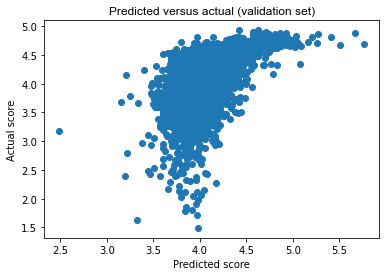

In [31]:
fig, ax = plt.subplots()
plt.scatter(y_pred,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

This model is overpredicting values

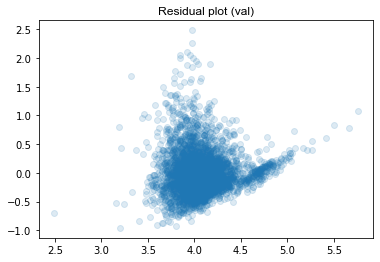

In [32]:
plt.scatter(check['pred'],check['resid'],alpha = 0.15)
plt.title('Residual plot (val)',family='arial',fontsize=12);

## Removing year

In [33]:
features2 = features.copy()
features2.remove('year')

In [34]:
lr2 = LinearRegression()

lr2.fit(X_train[features2], y_train)

y_pred2 = lr2.predict(X_val[features2])
print('R^2 of linear regression on val set: {:.2f}'.format(lr2.score(X_val[features2], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred2))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred2))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [35]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features2].columns, lr2.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
installs_day : 0.00
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.01
features : 1.04
bugs : -0.00
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.19
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.02
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.02
genre_Comics : 0.12
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Entertainment : -0.00
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.06
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.01
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography

In [36]:
check2 = X_val.copy()
check2['score'] = y_val
check2['pred'] = lr2.predict(X_val[features2])
check2['resid'] = check2['pred'] - check2['score']

In [37]:
check2.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.974115,2.481807
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.976768,2.264622
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807917,3.913752,2.105835
12165,8671.0,1,1,0,0,2793.296089,4,0,0.188985,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.788654,3.843864,2.055210
18204,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.958070,2.047802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,1590.0,1,1,0,0,3649.635036,138,0,-0.081088,0.440543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.662819,-0.865483
5454,39790.0,1,0,0,0,504.795558,8,1,0.215150,-0.083033,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.534046,3.656050,-0.877995
8717,17834.0,1,1,0,0,1522.070015,1,0,0.065115,0.000000,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.508447,3.593667,-0.914780
11720,35503.0,1,1,0,0,439.367311,1871,1,-0.061095,-0.128000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.801822,-0.919134


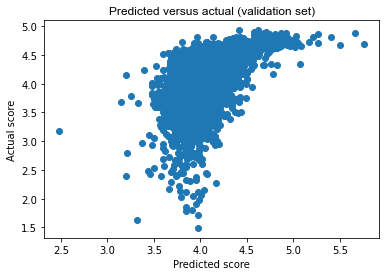

In [38]:
fig, ax = plt.subplots()
plt.scatter(y_pred2,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

## Removing installs / day

In [39]:
features3 = features2.copy()
features3.remove('installs_day')

In [40]:
lr3 = LinearRegression()

lr3.fit(X_train[features3], y_train)

y_pred3 = lr3.predict(X_val[features3])
print('R^2 of linear regression on val set: {:.2f}'.format(lr3.score(X_val[features3], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred3))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred3))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [41]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features3].columns, lr3.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.02
features : 1.04
bugs : -0.00
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.18
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.01
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.02
genre_Comics : 0.12
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Entertainment : -0.00
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.00
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography : -0.01
genre_Produ

In [42]:
check3 = X_val.copy()
check3['score'] = y_val
check3['pred'] = lr3.predict(X_val[features3])
check3['resid'] = check3['pred'] - check3['score']

In [43]:
check3.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.975436,2.483129
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.980267,2.268121
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807917,3.909503,2.101586
18204,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.960877,2.050610
12165,8671.0,1,1,0,0,2793.296089,4,0,0.188985,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.788654,3.835183,2.046529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,1590.0,1,1,0,0,3649.635036,138,0,-0.081088,0.440543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.651579,-0.876723
5454,39790.0,1,0,0,0,504.795558,8,1,0.215150,-0.083033,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.534046,3.655712,-0.878334
11720,35503.0,1,1,0,0,439.367311,1871,1,-0.061095,-0.128000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.802155,-0.918801
8717,17834.0,1,1,0,0,1522.070015,1,0,0.065115,0.000000,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.508447,3.589314,-0.919132


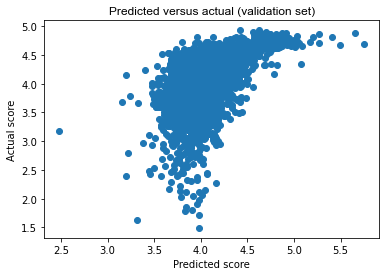

In [44]:
fig, ax = plt.subplots()
plt.scatter(y_pred3,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

## Removing updated days

In [45]:
#features4 = features3.copy()
#features4.remove('updated_days')

In [46]:
# lr4 = LinearRegression()

# lr4.fit(X_train[features4], y_train)

# y_pred4 = lr4.predict(X_val[features4])
# print('R^2 of linear regression on val set: {:.2f}'.format(lr4.score(X_val[features4], y_val)))
# print('MSE of linear regression on val set: {:.2f}'.format(mean_squared_error(y_val, y_pred4)))
# print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred4))))

In [47]:
# print('Feature coefficient results: \n')
# for feature, coef in zip(X_val[features4].columns, lr4.coef_):
#         print(feature, ':', f'{coef:.2f}')

In [48]:
# check3 = X_val.copy()
# check3['score'] = y_val
# check3['pred'] = lr3.predict(X_val[features3])
# check3['resid'] = check3['pred'] - check3['score']

In [49]:
# check3.sort_values('resid',ascending =False)

## Removing bugs

In [50]:
features5 = features3.copy()
features5.remove('bugs')

In [51]:
lr5 = LinearRegression()

lr5.fit(X_train[features5], y_train)

y_pred5 = lr5.predict(X_val[features5])
print('R^2 of linear regression on val set: {:.2f}'.format(lr5.score(X_val[features5], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred5))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred5))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [52]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features5].columns, lr5.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.02
features : 1.04
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.18
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.01
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.02
genre_Comics : 0.12
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Entertainment : -0.00
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.00
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography : -0.01
genre_Productivity : 0.0

In [53]:
check5 = X_val.copy()
check5['score'] = y_val
check5['pred'] = lr5.predict(X_val[features5])
check5['resid'] = check5['pred'] - check5['score']

In [54]:
check5.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.974942,2.482634
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.980591,2.268445
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807917,3.909756,2.101839
18204,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.961292,2.051024
12165,8671.0,1,1,0,0,2793.296089,4,0,0.188985,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.788654,3.835228,2.046574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,1590.0,1,1,0,0,3649.635036,138,0,-0.081088,0.440543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.650994,-0.877308
5454,39790.0,1,0,0,0,504.795558,8,1,0.215150,-0.083033,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.534046,3.655516,-0.878530
11720,35503.0,1,1,0,0,439.367311,1871,1,-0.061095,-0.128000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.803002,-0.917954
8717,17834.0,1,1,0,0,1522.070015,1,0,0.065115,0.000000,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.508447,3.589479,-0.918968


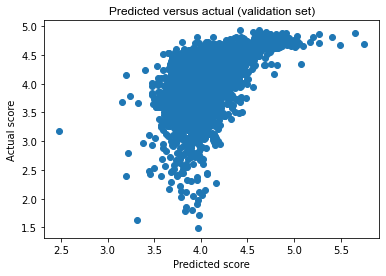

In [55]:
fig, ax = plt.subplots()
plt.scatter(y_pred5,y_val)
plt.title('Predicted versus actual (validation set)',family='arial',fontsize=12)
plt.xlabel('Predicted score')
plt.ylabel('Actual score');

## Removing Entertainment

In [56]:
features6 = features5.copy()
features6.remove('genre_Entertainment')

In [57]:
lr6 = LinearRegression()

lr6.fit(X_train[features6], y_train)

y_pred6 = lr6.predict(X_val[features6])
print('R^2 of linear regression on val set: {:.2f}'.format(lr6.score(X_val[features6], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred6))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred6))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [58]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features6].columns, lr6.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.02
features : 1.04
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.19
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.01
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.01
genre_Comics : 0.13
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.01
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography : -0.01
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre_

In [59]:
check6 = X_val.copy()
check6['score'] = y_val
check6['pred'] = lr6.predict(X_val[features6])
check6['resid'] = check6['pred'] - check6['score']

In [60]:
check6.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.975082,2.482774
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.980456,2.268310
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807917,3.909814,2.101897
18204,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.961450,2.051183
12165,8671.0,1,1,0,0,2793.296089,4,0,0.188985,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.788654,3.835151,2.046497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,1590.0,1,1,0,0,3649.635036,138,0,-0.081088,0.440543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.650762,-0.877540
5454,39790.0,1,0,0,0,504.795558,8,1,0.215150,-0.083033,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.534046,3.655582,-0.878464
11720,35503.0,1,1,0,0,439.367311,1871,1,-0.061095,-0.128000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.802855,-0.918101
8717,17834.0,1,1,0,0,1522.070015,1,0,0.065115,0.000000,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.508447,3.589709,-0.918737


## Removing bugs_libraries

In [61]:
features7 = features6.copy()
features7.remove('bugs_libraries')

In [62]:
lr7 = LinearRegression()

lr7.fit(X_train[features7], y_train)

y_pred7 = lr7.predict(X_val[features7])
print('R^2 of linear regression on val set: {:.2f}'.format(lr7.score(X_val[features7], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred7))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred7))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [63]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features7].columns, lr7.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.02
features : 1.04
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.19
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.01
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.01
genre_Comics : 0.13
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.01
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography : -0.01
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre_

In [64]:
check7 = X_val.copy()
check7['score'] = y_val
check7['pred'] = lr7.predict(X_val[features7])
check7['resid'] = check7['pred'] - check7['score']

In [65]:
check7.sort_values('resid',ascending =False)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,...,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.975082,2.482774
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.980456,2.268309
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.807917,3.909814,2.101897
18204,11487.0,1,1,0,0,580.383053,14,0,0.250500,0.129805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910268,3.961451,2.051184
12165,8671.0,1,1,0,0,2793.296089,4,0,0.188985,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.788654,3.835151,2.046497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18118,1590.0,1,1,0,0,3649.635036,138,0,-0.081088,0.440543,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.528302,3.650762,-0.877540
5454,39790.0,1,0,0,0,504.795558,8,1,0.215150,-0.083033,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.534046,3.655582,-0.878464
11720,35503.0,1,1,0,0,439.367311,1871,1,-0.061095,-0.128000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.720956,3.802854,-0.918102
8717,17834.0,1,1,0,0,1522.070015,1,0,0.065115,0.000000,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,4.508447,3.589709,-0.918738


## Removing edchoice_art

In [66]:
features8 = features7.copy()
features8.remove('edchoice_art')

In [67]:
lr8 = LinearRegression()

lr8.fit(X_train[features8], y_train)

y_pred8 = lr8.predict(X_val[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(X_val[features8], y_val)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_val, y_pred8))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_val, y_pred8))))

R^2 of linear regression on val set: 0.30
MSE of linear regression on val set: 0.15
MAE of linear regression on val set: 0.28


In [68]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.02
features : 1.04
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.19
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.01
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.01
genre_Comics : 0.13
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.01
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography : -0.01
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre_

In [69]:
check8 = X_val.copy()
check8['score'] = y_val
check8['pred'] = lr8.predict(X_val[features8])
check8['resid'] = check8['pred'] - check8['score']

In [70]:
pd.set_option('display.max_columns', None)

In [71]:
mid = check8[(check8['resid'] >= -0.1) & (check8['resid'] <= 0.1)]

In [72]:
mid[mid['genre_Tools'] == 1].groupby('year').count()

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2011,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2012,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2013,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2014,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
2015,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2016,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,

In [73]:
low = check8.sort_values('resid',ascending =False).head(200)

In [74]:
low.head(60)

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,year,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
11819,8452.0,1,0,0,0,479.386385,50,1,0.615933,0.210342,0.000000,0.143414,0.000000,0.000000,0.070067,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.088334,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.030166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.492308,3.975082,2.482774
14677,6004.0,1,0,0,0,303.122158,131,0,0.605733,0.033665,0.029350,0.180505,0.157864,0.000000,-0.361500,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.180505,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.109338,0.605733,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.006077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712146,3.980456,2.268309
20899,13478.0,1,0,0,0,1510.574018,394,1,0.160300,0.342556,0.829100,0.057172,0.228816,0.061800,0.660833,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.051238,0.0,0.0,0.0,0.00000,0.000000,0.009165,0.000000,0.000000,0.0000,0.0,

In [75]:
low[low['genre_Lifestyle'] == 1].groupby('year').count()
## photography - 2016
## Tools - 2017
## Entertainment - 2016

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2013,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2015,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2020,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [76]:
low_neg = check8.sort_values('resid',ascending =True).head(150)

In [77]:
low_neg[low_neg['genre_Lifestyle'] == 1].groupby('year').count()
##photgraphy - 2018 
## Entertaiment 2015

,ratings,free,containsAds,editorsChoice,top_developer,installs_day,updated_days,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2012,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2014,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2015,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2017,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2018,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2019,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,

### Test

In [78]:
X_test_cont = X_test[['ratings','free','updated_days','containsAds','editorsChoice','top_developer','has_video', 'app_ads', 'compatibility', 'updates', 
        'features', 'bugs','payments', 'use_support']]

In [79]:
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_test[['genre','contentRating']])

ohe_x_test = ohe.transform(X_test[['genre','contentRating']])

columns = ohe.get_feature_names(['genre','contentRating'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=X_test.index)

In [80]:
#Merge cont and cat DFs
combo_test_df = pd.concat([X_test_cont, ohe_x_test_df], axis=1)

In [81]:
combo_test_df.columns

Index(['ratings', 'free', 'updated_days', 'containsAds', 'editorsChoice',
       'top_developer', 'has_video', 'app_ads', 'compatibility', 'updates',
       'features', 'bugs', 'payments', 'use_support', 'genre_Action',
       'genre_Adventure', 'genre_Arcade', 'genre_Art & Design',
       'genre_Auto & Vehicles', 'genre_Beauty', 'genre_Board',
       'genre_Books & Reference', 'genre_Business', 'genre_Card',
       'genre_Casino', 'genre_Casual', 'genre_Comics', 'genre_Communication',
       'genre_Dating', 'genre_Education', 'genre_Entertainment',
       'genre_Finance', 'genre_Food & Drink', 'genre_Health & Fitness',
       'genre_House & Home', 'genre_Libraries & Demo', 'genre_Lifestyle',
       'genre_Maps & Navigation', 'genre_Medical', 'genre_Music & Audio',
       'genre_News & Magazines', 'genre_Parenting', 'genre_Personalization',
       'genre_Photography', 'genre_Productivity', 'genre_Puzzle',
       'genre_Racing', 'genre_Role Playing', 'genre_Shopping',
       'genre_Simu

In [82]:
## Add interactions
combo_test_df['use_support_weather'] = combo_test_df['use_support'] * combo_test_df['genre_Weather']
combo_test_df['use_support_shopping'] = combo_test_df['use_support'] * combo_test_df['genre_Shopping']
combo_test_df['use_support_education'] = combo_test_df['use_support'] * combo_test_df['genre_Education']
combo_test_df['use_support_Books'] = combo_test_df['use_support'] * combo_test_df['genre_Books & Reference']
combo_test_df['use_support_comics'] = combo_test_df['use_support'] * combo_test_df['genre_Comics']
combo_test_df['use_support_video'] = combo_test_df['use_support'] * combo_test_df['genre_Video Players & Editors']

combo_test_df['payments_food'] = combo_test_df['payments'] * combo_test_df['genre_Food & Drink']
combo_test_df['payments_medical'] = combo_test_df['payments'] * combo_test_df['genre_Medical']
combo_test_df['payments_shopping'] = combo_test_df['payments'] * combo_test_df['genre_Shopping']
combo_test_df['payments_news'] = combo_test_df['payments'] * combo_test_df['genre_News & Magazines']
combo_test_df['payments_casino'] = combo_test_df['payments'] * combo_test_df['genre_Casino']

combo_test_df['bugs_dating'] = combo_test_df['bugs'] * combo_test_df['genre_Dating']
combo_test_df['bugs_social'] = combo_test_df['bugs'] * combo_test_df['genre_Social']
combo_test_df['bugs_news'] = combo_test_df['bugs'] * combo_test_df['genre_News & Magazines']
combo_test_df['bugs_libraries'] = combo_test_df['bugs'] * combo_test_df['genre_Libraries & Demo']
combo_test_df['bugs_health'] = combo_test_df['bugs'] * combo_test_df['genre_Health & Fitness']
combo_test_df['bugs_casual'] = combo_test_df['bugs'] * combo_test_df['genre_Casual']
combo_test_df['bugs_comics'] = combo_test_df['bugs'] * combo_test_df['genre_Comics']

combo_test_df['features_tools'] = combo_test_df['features'] * combo_test_df['genre_Tools']
combo_test_df['features_news'] = combo_test_df['features'] * combo_test_df['genre_News & Magazines']
combo_test_df['features_music'] = combo_test_df['features'] * combo_test_df['genre_Music & Audio']
combo_test_df['features_card'] = combo_test_df['features'] * combo_test_df['genre_Card']
combo_test_df['features_business'] = combo_test_df['features'] * combo_test_df['genre_Business']
combo_test_df['features_house'] = combo_test_df['features'] * combo_test_df['genre_House & Home']

combo_test_df['updates_library'] = combo_test_df['updates'] * combo_test_df['genre_Libraries & Demo']
combo_test_df['updates_payments'] = combo_test_df['updates'] * combo_test_df['payments']
combo_test_df['updates_shopping'] = combo_test_df['updates'] * combo_test_df['genre_Shopping']
#combo_test_df['updates_events'] = combo_test_df['updates'] * combo_test_df['genre_Events']
combo_test_df['updates_art'] = combo_test_df['updates'] * combo_test_df['genre_Art & Design']

combo_test_df['app_ads_social'] = combo_test_df['app_ads'] * combo_test_df['genre_Social']
combo_test_df['app_ads_art'] = combo_test_df['app_ads'] * combo_test_df['genre_Art & Design']
combo_test_df['app_ads_strategy'] = combo_test_df['app_ads'] * combo_test_df['genre_Strategy']
combo_test_df['app_ads_features'] = combo_test_df['app_ads'] * combo_test_df['features']
combo_test_df['app_ads_tools'] = combo_test_df['app_ads'] * combo_test_df['genre_Tools']
combo_test_df['app_ads_entertainment'] = combo_test_df['app_ads'] * combo_test_df['genre_Entertainment']
combo_test_df['app_ads_house'] = combo_test_df['app_ads'] * combo_test_df['genre_House & Home']

combo_test_df['edchoice_Mature'] = combo_test_df['editorsChoice'] * combo_test_df['contentRating_Mature 17+']
combo_test_df['edchoice_teen'] = combo_test_df['editorsChoice'] * combo_test_df['contentRating_Teen']
combo_test_df['edchoice_education'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Education']
combo_test_df['edchoice_house'] = combo_test_df['editorsChoice'] * combo_test_df['genre_House & Home']
combo_test_df['edchoice_art'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Art & Design']
#combo_test_df['edchoice_events'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Events']
combo_test_df['edchoice_finance'] = combo_test_df['editorsChoice'] * combo_test_df['genre_Finance']

combo_test_df['ads_adventure'] = combo_test_df['containsAds'] * combo_test_df['genre_Adventure']
combo_test_df['ads_beauty'] = combo_test_df['containsAds'] * combo_test_df['genre_Beauty']
combo_test_df['ads_card'] = combo_test_df['containsAds'] * combo_test_df['genre_Card']
combo_test_df['ads_finance'] = combo_test_df['containsAds'] * combo_test_df['genre_Finance']
combo_test_df['ads_business'] = combo_test_df['containsAds'] * combo_test_df['genre_Business']
combo_test_df['ads_appads'] = combo_test_df['containsAds'] * combo_test_df['app_ads']
combo_test_df['ads_health'] = combo_test_df['containsAds'] * combo_test_df['genre_Health & Fitness']
combo_test_df['ads_roleplay'] = combo_test_df['containsAds'] * combo_test_df['genre_Role Playing']
combo_test_df['ads_maps'] = combo_test_df['containsAds'] * combo_test_df['genre_Maps & Navigation']
combo_test_df['ads_photography'] = combo_test_df['containsAds'] * combo_test_df['genre_Photography']

#combo_test_df['compatibility_events'] = combo_test_df['compatibility'] * combo_test_df['genre_Events']
combo_test_df['compatibility_medical'] = combo_test_df['compatibility'] * combo_test_df['genre_Medical']
combo_test_df['compatibility_productivity'] = combo_test_df['compatibility'] * combo_test_df['genre_Productivity']
combo_test_df['compatibility_adventure'] = combo_test_df['compatibility'] * combo_test_df['genre_Adventure']
combo_test_df['compatibility_communication'] = combo_test_df['compatibility'] * combo_test_df['genre_Communication']
combo_test_df['compatibility_news'] = combo_test_df['compatibility'] * combo_test_df['genre_News & Magazines']
combo_test_df['compatibility_features'] = combo_test_df['compatibility'] * combo_test_df['features']

combo_test_df['video_medical'] = combo_test_df['has_video'] * combo_test_df['genre_Medical']
combo_test_df['video_library'] = combo_test_df['has_video'] * combo_test_df['genre_Libraries & Demo']
combo_test_df['video_sport'] = combo_test_df['has_video'] * combo_test_df['genre_Sports']
combo_test_df['video_comics'] = combo_test_df['has_video'] * combo_test_df['genre_Comics']

combo_test_df['topdev_video'] = combo_test_df['top_developer'] * combo_test_df['genre_Video Players & Editors']
combo_test_df['topdev_features'] = combo_test_df['top_developer'] * combo_test_df['features']
combo_test_df['topdev_personalization'] = combo_test_df['top_developer'] * combo_test_df['genre_Personalization']

combo_test_df['free_simulation'] = combo_test_df['free'] * combo_test_df['genre_Simulation']
combo_test_df['free_Photography'] = combo_test_df['free'] * combo_test_df['genre_Photography']

In [83]:
y_pred_test = lr8.predict(combo_test_df[features8])
print('R^2 of linear regression on val set: {:.2f}'.format(lr8.score(combo_test_df[features8], y_test)))
print('MSE of linear regression on val set: {:.2f}'.format((mean_squared_error(y_test, y_pred_test))))
print('MAE of linear regression on val set: {:.2f}'.format((mean_absolute_error(y_test, y_pred_test))))

R^2 of linear regression on val set: 0.31
MSE of linear regression on val set: 0.14
MAE of linear regression on val set: 0.27


In [84]:
check9 = combo_test_df.copy()
check9['score'] = y_test
check9['pred'] = lr8.predict(combo_test_df[features8])
check9['resid'] = check9['pred'] - check9['score']

In [85]:
check9.sort_values('pred',ascending=False)

,ratings,free,updated_days,containsAds,editorsChoice,top_developer,has_video,app_ads,compatibility,updates,features,bugs,payments,use_support,genre_Action,genre_Adventure,genre_Arcade,genre_Art & Design,genre_Auto & Vehicles,genre_Beauty,genre_Board,genre_Books & Reference,genre_Business,genre_Card,genre_Casino,genre_Casual,genre_Comics,genre_Communication,genre_Dating,genre_Education,genre_Entertainment,genre_Finance,genre_Food & Drink,genre_Health & Fitness,genre_House & Home,genre_Libraries & Demo,genre_Lifestyle,genre_Maps & Navigation,genre_Medical,genre_Music & Audio,genre_News & Magazines,genre_Parenting,genre_Personalization,genre_Photography,genre_Productivity,genre_Puzzle,genre_Racing,genre_Role Playing,genre_Shopping,genre_Simulation,genre_Social,genre_Sports,genre_Strategy,genre_Tools,genre_Travel & Local,genre_Trivia,genre_Video Players & Editors,genre_Weather,genre_Word,contentRating_Everyone,contentRating_Everyone 10+,contentRating_Mature 17+,contentRating_Teen,use_support_weather,use_support_shopping,use_support_education,use_support_Books,use_support_comics,use_support_video,payments_food,payments_medical,payments_shopping,payments_news,payments_casino,bugs_dating,bugs_social,bugs_news,bugs_libraries,bugs_health,bugs_casual,bugs_comics,features_tools,features_news,features_music,features_card,features_business,features_house,updates_library,updates_payments,updates_shopping,updates_art,app_ads_social,app_ads_art,app_ads_strategy,app_ads_features,app_ads_tools,app_ads_entertainment,app_ads_house,edchoice_Mature,edchoice_teen,edchoice_education,edchoice_house,edchoice_art,edchoice_finance,ads_adventure,ads_beauty,ads_card,ads_finance,ads_business,ads_appads,ads_health,ads_roleplay,ads_maps,ads_photography,compatibility_medical,compatibility_productivity,compatibility_adventure,compatibility_communication,compatibility_news,compatibility_features,video_medical,video_library,video_sport,video_comics,topdev_video,topdev_features,topdev_personalization,free_simulation,free_Photography,score,pred,resid
10797,315172.0,1,23,1,0,1,0,0.574680,0.253783,-0.757900,0.229704,0.156567,0.176108,0.729850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.72985,0.0000,0.0,0.0,0.0,0.0,0.0,0.176108,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-0.0,-0.133472,-0.7579,-0.0,0.0,0.0,0.0,0.132007,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.058295,0.0,0.0,0.0,0.0,0.0,0.229704,0.0,0.0,0.0,4.699142,6.042624,1.343483
15152,368224.0,1,7,0,0,1,1,0.690800,-0.532400,0.038570,0.005271,-0.032100,0.000000,0.655900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.6559,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.0,-0.0,-0.00000,-0.0,-0.0,-0.0,-0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.003641,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.000,-0.002806,0.0,0.0,0.0,0.0,0.0,0.005271,0.0,0.0,0.0,4.944825,5.737971,0.793147
3861,362672.0,1,63,1,0,1,1,0.308287,0.159575,0.344733,0.360117,0.000000,0.215656,0.175067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.074344,0.0000,0.0,0.0,0.0,0.0,0.111020,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.057466,0.0,0.0,0.0,0.0,0.0,0.360117,0.0,0.0,0.0,4.657820,5.720493,1.062673
20650,36013

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


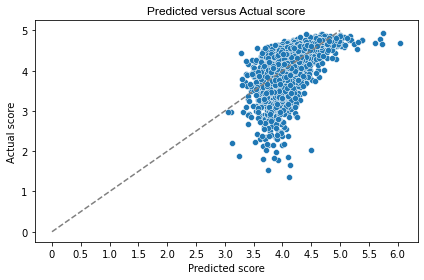

In [86]:
fig, ax = plt.subplots()
sns.scatterplot(y_pred_test,y_test)
plt.xlabel('Predicted score')
plt.ylabel('Actual score')
ax.plot(np.linspace(0,5,5), np.linspace(0,5,5), ls="--", c="0.5")
plt.tight_layout()
plt.title('Predicted versus Actual score',family='arial',fontsize=12);
plt.xticks(np.linspace(0,5,11), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])
plt.xticks(np.linspace(0,6,13), ['0','0.5','1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0','5.5','6.0'])
plt.tight_layout()
plt.savefig('predictedactual_apps.svg');
plt.show;

In [90]:
print('Feature coefficient results: \n')
for feature, coef in zip(X_val[features8].columns, lr8.coef_):
        print(feature, ':', f'{coef:.2f}')

Feature coefficient results: 

ratings : 0.00
free : 0.09
containsAds : 0.06
editorsChoice : 0.01
top_developer : 0.66
updated_days : -0.00
has_video : 0.05
app_ads : 0.20
compatibility : 0.07
updates : -0.02
features : 1.04
payments : 0.04
use_support : 0.04
genre_Adventure : 0.02
genre_Arcade : 0.02
genre_Art & Design : -0.09
genre_Auto & Vehicles : 0.10
genre_Beauty : 0.19
genre_Board : 0.08
genre_Books & Reference : 0.11
genre_Business : 0.01
genre_Card : 0.15
genre_Casino : 0.06
genre_Casual : -0.01
genre_Comics : 0.13
genre_Communication : 0.07
genre_Dating : -0.07
genre_Education : 0.04
genre_Finance : 0.04
genre_Food & Drink : 0.11
genre_Health & Fitness : -0.04
genre_House & Home : 0.36
genre_Libraries & Demo : -0.05
genre_Lifestyle : 0.02
genre_Maps & Navigation : -0.02
genre_Medical : 0.11
genre_Music & Audio : 0.01
genre_News & Magazines : -0.17
genre_Parenting : 0.07
genre_Personalization : 0.16
genre_Photography : -0.01
genre_Productivity : 0.07
genre_Puzzle : 0.12
genre_

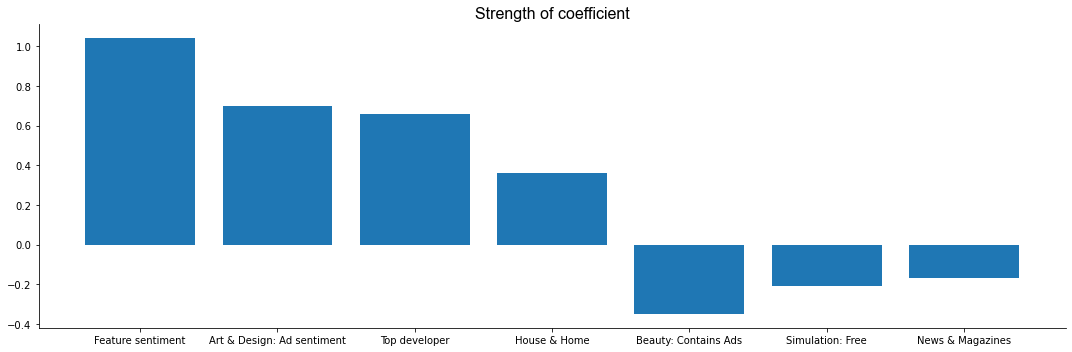

In [93]:
x_values = [1.04,0.70,0.66,0.36,-0.35,-0.21,-0.17]
x_labels = ['Feature sentiment','Art & Design: Ad sentiment','Top developer','House & Home','Beauty: Contains Ads','Simulation: Free','News & Magazines']

plt.figure(figsize=[15,5])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(x_labels,x_values)   
plt.title('Strength of coefficient',family='arial',fontsize=16)
plt.tight_layout()
plt.savefig('coefficients_apps.svg');
plt.show;

### Create dataframe for tableau

In [88]:
df_tableau = df.copy()
df_tableau = df_tableau.drop(columns=['installs','description','summary','histogram','released','currency',
                                     'sale','offersIAP','inAppProductPrice',
                                     'androidVersion','androidVersionText',
                                     'developer','developerId','privacyPolicy',
                                     'developerInternalID','genreId', 'icon', 'headerImage',
                                     'screenshots', 'video', 'videoImage',
                                     'updated', 'version', 'recentChanges', 'comments',
                                     'url','hist_clean','current_date',
                                     'contentRatingDescription','adSupported'])

In [89]:
#df_tableau.to_csv('dataframe_tableau.csv')